In [1]:
# Configuring environment parameters
import os
import json 
import logging

logging.basicConfig(
    filename='log/app.log',            # Specify the log file name
    level=logging.DEBUG,           # Set the log level (DEBUG, INFO, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(levelname)s - %(message)s'  # Set the log format
)

# Load the environment configuration JSON data
json_path = 'env_config.json'
with open(json_path, 'r') as file:
    env_config = json.load(file)

hf_home = env_config['HF_HOME']
# Set the HF_HOME environment variable
os.environ['HF_HOME'] = hf_home
# Set the access token to huggingface hub
access_token = env_config['access_token']
os.environ['HUGGINGFACE_HUB_TOKEN'] = access_token

In [2]:
# Loading necessary packages
import transformers 
import torch

from accelerate import Accelerator
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, LlamaForTokenClassification #, LlamaRotaryEmbedding
# from transformers import LlamaTokenizerFast
import torch.nn.functional as F

from llmexp.helper import DataHelper
from datasets import load_dataset
from torch.utils.data import DataLoader

# TODO 注意load正确的模型
# from llmexp.imdb_model import MaskGeneratingModelForIMDB
from llmexp.insertion_model import MaskGeneratingModelForInsertion
from tqdm import tqdm

In [3]:
# Load datasets
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id, token=access_token, padding_side='left')
tokenizer.pad_token = tokenizer.eos_token

# ds = load_dataset("imdb")
ds = load_dataset("rajpurkar/squad")
# ds = load_dataset("stanfordnlp/sst2")
train_ds = ds['train']
# test_ds = ds['test']
test_ds = ds['validation']

llm_exp_helper = DataHelper(tokenizer)
collate_fn = llm_exp_helper.get_collate_fun('squad')
# collate_fn = llm_exp_helper.get_collate_fun('imdb')

# Define batch size here!
batch_size = 16
train_dataloader = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
test_dataloader = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

In [4]:
# Configure and load model
accelerator = Accelerator()
device = accelerator.device
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# model_id = "meta-llama/Meta-Llama-3-8B"  # non-instruct version

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    # device_map="auto",
    device_map=device,
    token=access_token,
)

config = model.config

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
mask_gen_model = MaskGeneratingModelForInsertion()
mask_gen_model.to(device)

# Set pad_token_id if it is not set
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

`LlamaRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.45


In [6]:
data = next(iter(train_dataloader))

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
context_mask = data['context_mask'].to(device)
# get generated texts
gen_outputs = model.generate(
    input_ids=input_ids,
    attention_mask=attention_mask,
    max_new_tokens=128,
    eos_token_id=terminators,
    pad_token_id=tokenizer.pad_token_id,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
    return_dict_in_generate=True,
    output_scores=True,
)
gen_tokens = gen_outputs.sequences
pad_length = gen_tokens.size(1) - input_ids.size(1)
# get the attention mask for the generated tokens, and also mask the padding tokens
gen_attention_mask = F.pad(attention_mask, (0, pad_length), mode='constant', value=1)
# (gen_tokens != pad_token_id).long() is the tokens mask, 1 for real tokens and 0 for padding tokens
unpaded_token_mask = (gen_tokens != tokenizer.pad_token_id).long()
unpaded_token_mask[:, :-pad_length] = 1
gen_attention_mask = gen_attention_mask * unpaded_token_mask

# get the response mask, which is the mask for the generated tokens (the user inputs are masked with 0)
response_mask = gen_attention_mask.clone()
response_mask[:, :-pad_length] = 0 # TODO: 有问题. 有问题吗？

context_mask = F.pad(context_mask, (0, pad_length), mode='constant', value=0)

In [9]:
new_input_ids = gen_tokens
new_attention_mask = gen_attention_mask
new_context_mask = context_mask

sim_upper, correct_logprob_upper, log_probs, _, _ = mask_gen_model.calculate_sim(model, new_input_ids, new_attention_mask, response_mask, labels=new_input_ids)

def get_masked_input_ids(input_ids, mask, context_mask):
    to_be_masked = (1 - mask) * context_mask
    masked_input_ids = input_ids.clone()
    masked_input_ids[to_be_masked == 1] = tokenizer.pad_token_id
    return masked_input_ids

mask = (1 - new_context_mask) * new_attention_mask
masked_input_ids = get_masked_input_ids(new_input_ids, mask, new_context_mask)

sim_lower, correct_logprob_lower, log_probs_lower, shift_response_mask, new_response_mask = mask_gen_model.calculate_sim(model, masked_input_ids, new_attention_mask, response_mask, labels=new_input_ids)

rewards = mask_gen_model.progressive_insertion_action(model, new_input_ids, new_attention_mask, new_context_mask, response_mask, num_steps=20)

/afs/crc.nd.edu/user/d/dpan/.local/lib/python3.12/site-packages/torch/nn/functional.py:2994: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


reward_raw: tensor(-0.5157, device='cuda:0') reward: tensor(0.4361, device='cuda:0') factor: tensor(0.0482, device='cuda:0')
reward_raw: tensor(-0.4797, device='cuda:0') reward: tensor(0.4230, device='cuda:0') factor: tensor(0.0973, device='cuda:0')
reward_raw: tensor(-0.4293, device='cuda:0') reward: tensor(0.4219, device='cuda:0') factor: tensor(0.1488, device='cuda:0')
reward_raw: tensor(-0.3720, device='cuda:0') reward: tensor(0.4383, device='cuda:0') factor: tensor(0.1897, device='cuda:0')
reward_raw: tensor(-0.3142, device='cuda:0') reward: tensor(0.4262, device='cuda:0') factor: tensor(0.2596, device='cuda:0')
reward_raw: tensor(-0.2904, device='cuda:0') reward: tensor(0.4250, device='cuda:0') factor: tensor(0.2846, device='cuda:0')
reward_raw: tensor(-0.2433, device='cuda:0') reward: tensor(0.4180, device='cuda:0') factor: tensor(0.3387, device='cuda:0')
reward_raw: tensor(-0.0883, device='cuda:0') reward: tensor(0.5107, device='cuda:0') factor: tensor(0.4010, device='cuda:0')


In [8]:
rewards.shape

torch.Size([16, 20])

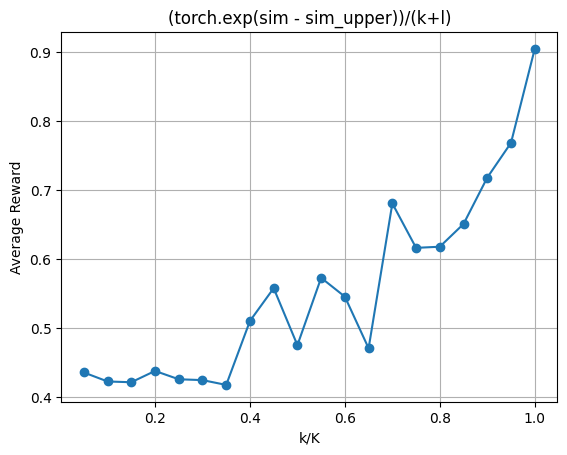

In [10]:
import matplotlib.pyplot as plt
import numpy as np

rewards_mean = rewards.mean(axis=0)
K = rewards_mean.size(0)
x = np.arange(1, K+1) / K

plt.plot(x, rewards_mean.detach().cpu(), marker='o')
plt.xlabel('k/K')
plt.ylabel('Average Reward')
plt.title('(torch.exp(sim - sim_upper))/(k+l)')
plt.grid(True)
plt.show()